We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import itertools

import joblib
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.connectivity import reshape_pvalues, network_to_network_connectivity
from bold_dementia.connectivity.matrices import plot_matrix
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.histograms import fast_hist
from bold_dementia.utils.iterables import unique, itersize

ATLAS = "rsn41"
SOFT = False
matrices_path = Path(
    f"{config['data_dir']}/output/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-full_wm_csf-basic"
)

In [2]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

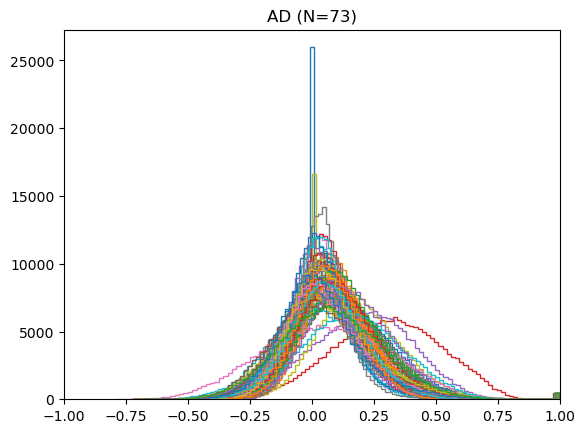

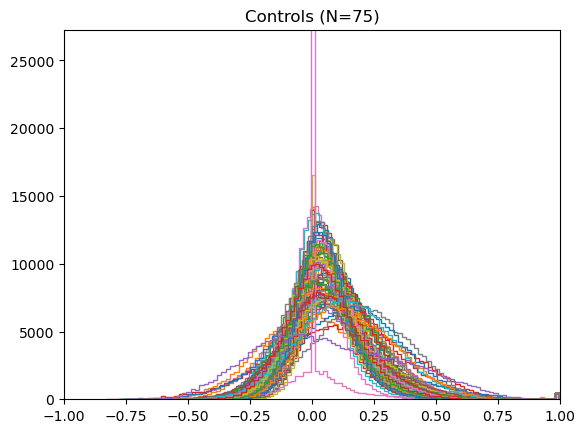

In [3]:
_, ax = fast_hist(AD_matrices, bins=100) 
ax.set_title(f"AD (N={n_AD})")
plt.show()

control_subsampled = control_matrices[::(n_controls//n_AD), :, :]
fig, ax2 = fast_hist(control_subsampled, bins=100) 
ax2.set_ylim(ax.get_ylim())
ax2.set_title(f"Controls (N={control_subsampled.shape[0]})")

plt.show()

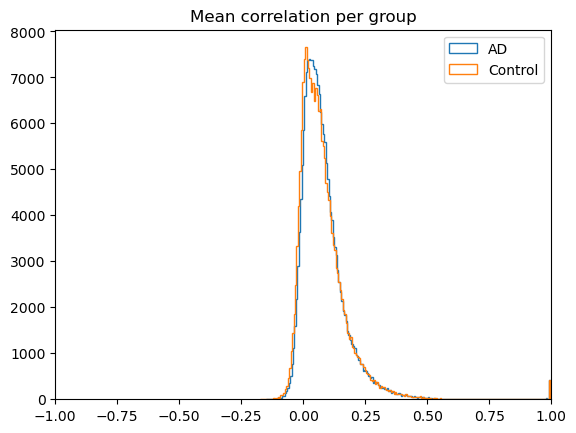

In [4]:
plt.hist(AD_matrices.mean(axis=0).flatten(), histtype="step", label="AD", bins=200)
plt.hist(control_matrices.mean(axis=0).flatten(), histtype="step", label="Control", bins=200)
plt.xlim(-1, 1)
plt.legend()
plt.title("Mean correlation per group")
plt.show()

In [5]:

def group_by_networks(macro_labels):
    networks = np.array(macro_labels)
    sort_index = np.argsort(networks)

    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label

    ticks.append(i)
    return ticks, sort_index

In [6]:
ticks, sort_index = group_by_networks(atlas.macro_labels)

matrix_sort = np.ix_(sort_index, sort_index)
AD = AD_matrices.mean(axis=0)[matrix_sort]
control = control_matrices.mean(axis=0)[matrix_sort]

for mat in (AD, control):
    mat[list(range(n_regions)), list(range(n_regions))] = 0

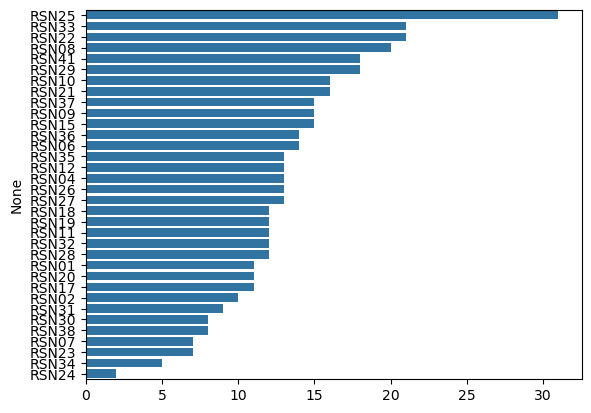

In [13]:

names, counts = np.unique(np.array(atlas.macro_labels), return_counts=True)
s = pd.Series(dict(zip(tuple(names), tuple(counts)))).sort_values(ascending=False)
sns.barplot(y=s.index, x=s.values)
plt.show()


In [8]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))

network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

RSN01       (0, 11)
RSN02      (11, 21)
RSN04      (21, 34)
RSN06      (34, 48)
RSN07      (48, 55)
RSN08      (55, 75)
RSN09      (75, 90)
RSN10     (90, 106)
RSN11    (106, 118)
RSN12    (118, 131)
RSN15    (131, 146)
RSN17    (146, 157)
RSN18    (157, 169)
RSN19    (169, 181)
RSN20    (181, 192)
RSN21    (192, 208)
RSN22    (208, 229)
RSN23    (229, 236)
RSN24    (236, 238)
RSN25    (238, 269)
RSN26    (269, 282)
RSN27    (282, 295)
RSN28    (295, 307)
RSN29    (307, 325)
RSN30    (325, 333)
RSN31    (333, 342)
RSN32    (342, 354)
RSN33    (354, 375)
RSN34    (375, 380)
RSN35    (380, 393)
RSN36    (393, 407)
RSN37    (407, 422)
RSN38    (422, 430)
RSN41    (430, 447)
dtype: object

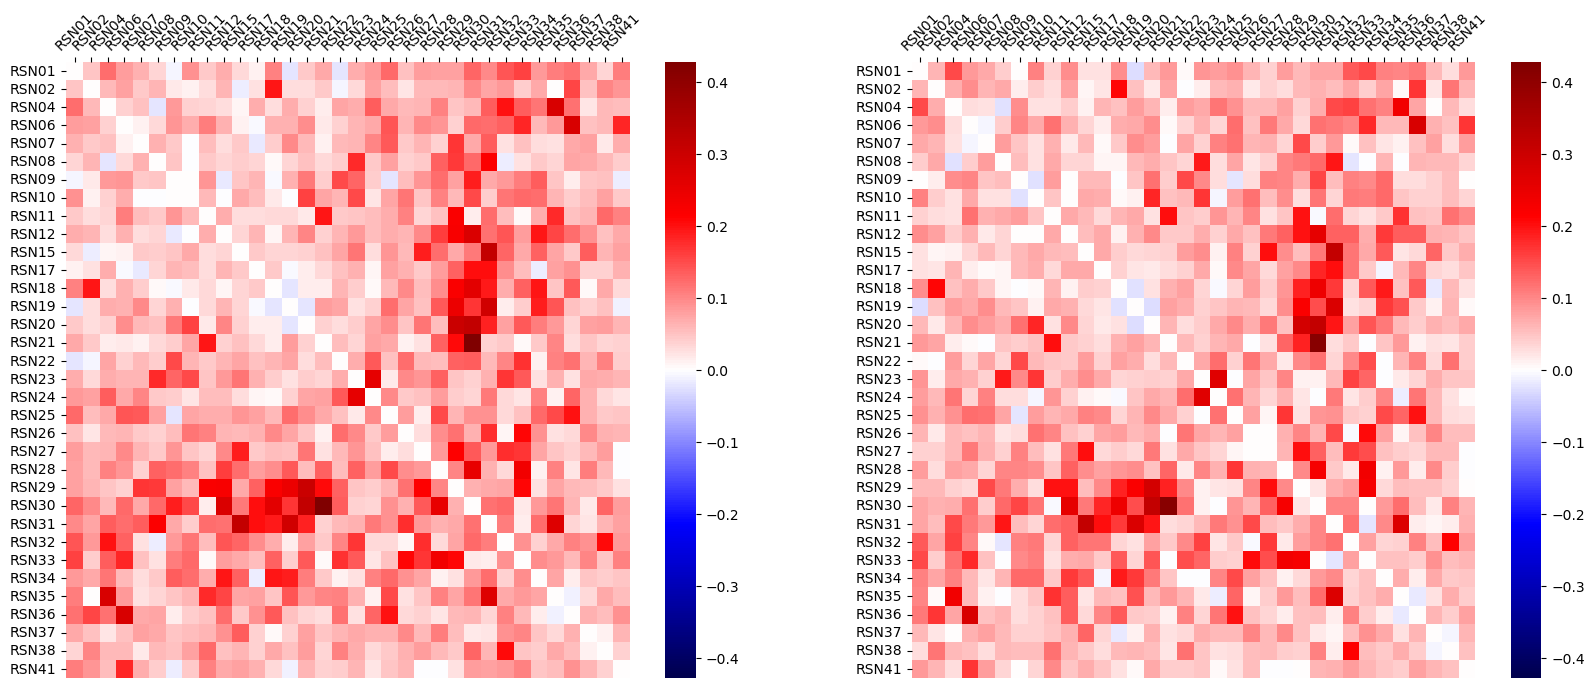

In [19]:
AD_nnc = network_to_network_connectivity(AD, network_to_idx)
control_nnc = network_to_network_connectivity(control, network_to_idx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


AD_nnc_mat = reshape_pvalues([ic[2] for ic in AD_nnc])
control_nnc_mat = reshape_pvalues([ic[2] for ic in control_nnc])

AD_span = np.max(abs(AD_nnc_mat))
control_span = np.max(abs(control_nnc_mat))
span = max(AD_span, control_span)
heat_kwargs = {"vmin": -span, "vmax":span, "cmap":"seismic", "xticklabels":unique_m, "yticklabels":unique_m}

sns.heatmap(AD_nnc_mat, ax=ax1, **heat_kwargs)

sns.heatmap(control_nnc_mat, ax=ax2, **heat_kwargs)

ax1.tick_params(axis="x", labelrotation=45)
ax1.xaxis.tick_top()
ax2.tick_params(axis='x', labelrotation=45)
ax2.xaxis.tick_top()

plt.show()

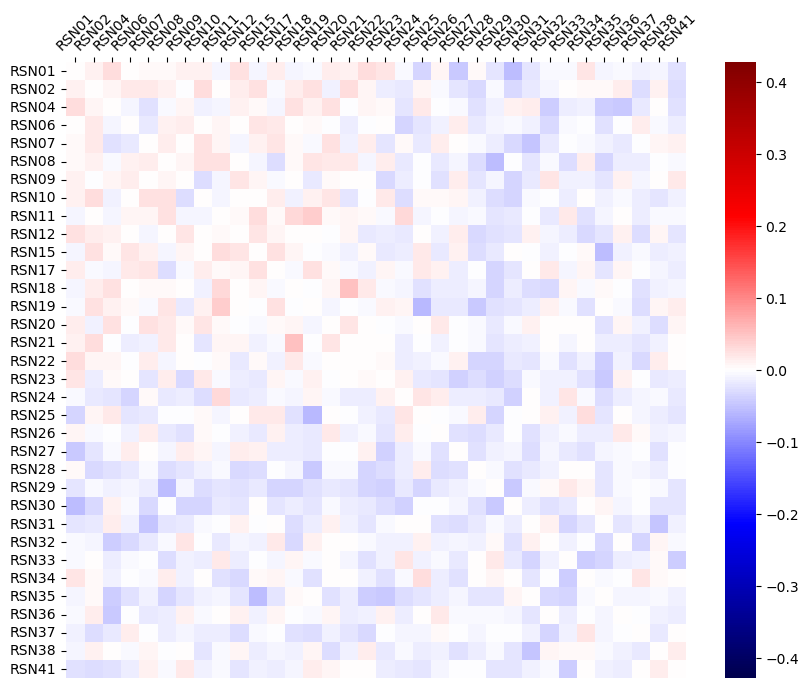

In [18]:
diff = control_nnc_mat - AD_nnc_mat
dspan = np.max(abs(diff))

try:
    heat_kwargs.pop("vmin")
    heat_kwargs.pop("vmax")
except KeyError:
    pass

plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(diff, vmin=-span,vmax=span, **heat_kwargs)
ax.xaxis.tick_top()
ax.tick_params(axis="x", labelrotation=45)

(array([ 12.,  36.,  92., 220., 296., 270., 158.,  64.,   4.,   4.]),
 array([-0.05748308, -0.04653065, -0.03557822, -0.02462579, -0.01367336,
        -0.00272093,  0.0082315 ,  0.01918393,  0.03013636,  0.04108879,
         0.05204122]),
 [<matplotlib.patches.Polygon at 0x7f6804eb6750>])

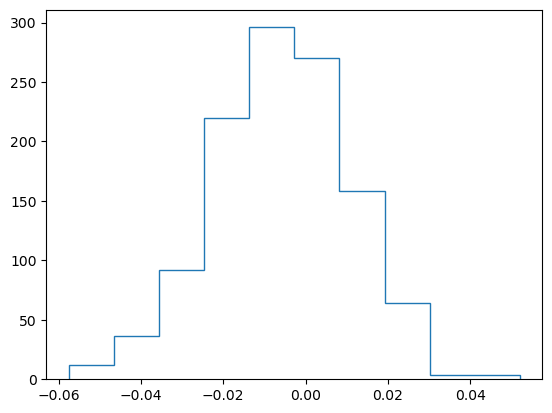

In [12]:
plt.hist(diff.flatten(), histtype="step")